In [2]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sb
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import linregress
from collections import Counter
from urllib.parse import urljoin

 Scraping the website
1. We got the links to individual faculty profiles form the faculty page of Mechanical Engineering Department of IIT-B ("https://www.me.iitb.ac.in/?q=full-time-faculty")
2. The HTML code of one of the links was then analysed to find the tags associated with information we need to scrape and store.


In [3]:
#Function that takes url of a website as input and returns list of  urls on that website
def link(url):
    urls = []
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    base_url = url  # Store the base URL to convert relative paths to absolute URLs
    links = soup.find_all('a')
    
    for link in links:
        href = link.get('href')
        if href:
            full_url = urljoin(base_url, href)  # Convert the relative path to an absolute URL
            urls.append(full_url)
    
    return urls





In [4]:
#List of all the limks on the facukty page
all_links_facultypage = link("https://www.me.iitb.ac.in/?q=full-time-faculty")
all_links_facultypage

['https://www.me.iitb.ac.in/?q=full-time-faculty#main',
 'https://www.me.iitb.ac.in/?q=full-time-faculty#main-nav',
 'https://www.me.iitb.ac.in/',
 'https://www.me.iitb.ac.in/',
 'https://www.me.iitb.ac.in/',
 'https://www.me.iitb.ac.in/?q=academics',
 'https://www.me.iitb.ac.in/',
 'https://www.me.iitb.ac.in/?q=full-time-faculty',
 'https://www.me.iitb.ac.in/?q=honorary-faculty-members',
 'https://www.me.iitb.ac.in/?q=administrative-staff',
 'https://www.me.iitb.ac.in/?q=administrative-staff',
 'https://www.me.iitb.ac.in/?q=technical-staff',
 'https://www.me.iitb.ac.in/?q=post-doctoral-staff',
 'https://www.me.iitb.ac.in/?q=research-slider',
 'https://www.me.iitb.ac.in/?q=research-group/Thermal%20and%20Fluids%20Engineering',
 'https://www.me.iitb.ac.in/?q=research-group/Design%20Engineering',
 'https://www.me.iitb.ac.in/?q=research-group/Manufacturing%20Engineering',
 'https://www.me.iitb.ac.in/?q=all-publications-new',
 'https://www.me.iitb.ac.in/',
 'http://www.iitbracing.org',
 'ht

In [5]:
#Filtering only the faculty profile links and removing duplicates using set
target_portion = "https://www.me.iitb.ac.in/?q=faculty/Prof."
filtered_urls = [url for url in all_links_facultypage if target_portion in url and not url.endswith('%20')]
all_faculty_set = set(filtered_urls)
all_faculty = list(all_faculty_set)
all_faculty

['https://www.me.iitb.ac.in/?q=faculty/Prof.%20U.%20V.%20Bhandarkar',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Arunkumar%20Sridharan',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Sandip%20Kumar%20Saha',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Shantanu%20Tripathi',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Atul%20Sharma%28Head%20of%20the%20Department%29',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Nitesh%20P.%20Yelve',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Pradeep%20Dixit',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Krishna%20Jonnalagadda',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Bhalchandra%20Puranik',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20B.%20Ravi',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Shankar%20Krishnan',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Sushil%20Mishra',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Dnyanesh%20Pawaskar',
 'https://www.me.iitb.ac.in/?q=faculty/Prof.%20Rajendra%20P.%20Vedula',
 'https://ww

In [5]:
#html code of faculty
page = requests.get('https://www.me.iitb.ac.in/?q=faculty/Prof.%20Sandip%20Kumar%20Saha')
soup = BeautifulSoup(page.content, "html.parser")
soup

<!DOCTYPE html>

<!--[if lt IE 7]> <html class="ie6 ie" lang="en" dir="ltr"> <![endif]-->
<!--[if IE 7]>    <html class="ie7 ie" lang="en" dir="ltr"> <![endif]-->
<!--[if IE 8]>    <html class="ie8 ie" lang="en" dir="ltr"> <![endif]-->
<!--[if IE 9]>    <html class="ie9 ie" lang="en" dir="ltr"> <![endif]-->
<!--[if !IE]> --> <html dir="ltr" lang="en"> <!-- <![endif]-->
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="Drupal 7 (http://drupal.org)" name="Generator"/>
<!-- Set the viewport width to device width for mobile -->
<meta content="width=device-width, initial-scale=1.0" name="viewport"/>
<title>Faculty | IIT Mechanical</title>
<style media="all" type="text/css">
@import url("https://www.me.iitb.ac.in/modules/system/system.base.css?pwy1af");
@import url("https://www.me.iitb.ac.in/modules/system/system.menus.css?pwy1af");
@import url("https://www.me.iitb.ac.in/modules/system/system.messages.css?pwy1af");
@import url("https://www.me.iitb.ac.

In [6]:
# Function to scrape out all the information from faculty page. Takes the page url as imput and returns details like 
#position education details, professional experience, research interest, publications as list
def parse(url):
 
    try:
        # Add a timeout parameter (in seconds) to the request
        page = requests.get(url, timeout=60)  # Timeout set to 10 seconds
        page.raise_for_status()  # Raise HTTPError for bad requests
        
        soup = BeautifulSoup(page.content, "html.parser")
        
        #Name
        name_tag = soup.find('h2', class_='text')
        faculty_name = [name_tag.get_text()] if name_tag else []
        
        #Position
        name_h2 = soup.find('h2')
        br_tag = name_h2.find_next('br')  # Find the <br/> tag following the name as name and position were separated by <br>
        position = [br_tag.find_next_sibling('br').previous_sibling.strip()]
       
        #Education was as paragraphs with each degree separated by br
        edu = soup.find('span', class_='views-field views-field-field-acadamic-background')
        edu_text = edu.find('p').get_text() if edu else [] 
        edu_list1 = [item.strip() for item in edu_text.split('<br/>') if item.strip()] if edu_text else []
        edu_list = [item.replace('\n', '}') for item in edu_list1]  #list for education, with each degree separated by }
        
       
        #Professional experience: Need to check for 'prof_exp' in both <li> and <p> tags due to non-unoformity across websites
        prof_exp = soup.find('span', class_="views-field views-field-field-professional-experience")
        prof_text = ''
        if prof_exp:
            li_tag = prof_exp.find('li')
            if li_tag:
                prof_text = li_tag.get_text()
            else:
                p_tag = prof_exp.find('p')
                if p_tag:
                    prof_text = p_tag.get_text()

        pe_list = [item.strip() for item in prof_text.split('<br/>') if item.strip()] if prof_text else [] #professional experience list
        
        #Publication
        pub = soup.find_all('div', class_='field-content')
        pub_list = [div.get_text(strip=True) for div in pub] if pub else []  #publication list
        
        # Research Interest: Check for 'ri' in both <li> and <p> tags again  due to non-unoformity across websites
        ri = soup.find('span', class_='views-field views-field-field-research-intrests')
        ri_text = ''
        if ri:
            li_tag = ri.find('li')
            if li_tag:
                ri_text = li_tag.get_text()
            else:
                p_tag = ri.find('p')
                if p_tag:
                    ri_text = p_tag.get_text()
        ri_list = [item.strip() for item in ri_text.split('<br/>') if item.strip()] if ri_text else []   #Research Interest list         
        
        #List of all details
        faculty_mech_info = [faculty_name, position, edu_list, ri_list, pe_list, pub_list ]
        
    
        return faculty_mech_info
       
    #To handle errors
    except requests.exceptions.Timeout:
        print(f"Timeout occurred while accessing {url}")
        return [], [], [], [], []
    except requests.exceptions.HTTPError as errh:
        print(f"HTTP Error occurred: {errh}")
        return [], [], [], [], []
    except requests.exceptions.RequestException as err:
        print(f"Request Exception occurred: {err}")
        return [], [], [], [], []
   

        
    


In [8]:
#Example list with details of one faculty
x = parse('https://www.me.iitb.ac.in/?q=faculty/Prof.%20Prashant%20P.%20Date')
x


[['Prof. Prashant P. Date'],
 ['Professor'],
 ['Ph.D. (Metal Forming) IIT Madras, 1992,}MTech Industrial Metallurgy, IIT Madras, 1987,}B.E. (Mechanical Engg.) CoEP, Pune University'],
 ['Metal Forming Processes, Formability, Shopfloor Metallic waste processing, Powder Metallurgy, Metal Injection Moulding'],
 [],
 ['Alexandrov S., Date P.,An alternative interpretation of axial friction test results for viscoplastic materials,Mechanics of Time-Dependent Materials,22,2,2018,259.',
  'Lyamina E.A., Kalenova N.V., Date P.P.,A stationary bulk planar ideal flow solution for the double shearing model,Journal of Physics: Conference Series,991,1,2018,12053.',
  'Doifode D.S., Deorukhkar B.D., Date P.P., Alexandrov S.,Rheological behavior of mixture of carbonyl iron powder (CIP) and high density polyethylene (HDPE),Key Engineering Materials,779 KEM,,2018,31.',
  'Deorukhkar B.D., Doifode D.S., Date P.P., Alexandrov S.,Room temperature compression behavior of mixtures of carbonyl iron powder and H

In [9]:
#Can be used to print details of a ll faculty as lists
for i in all_faculty:
    print(parse(i))
    
   

[['Prof. Milind Atrey'], ['Professor'], [], ['Refrigeration,Cryogenic Engineering,Cryocoolers, Cryogenic Heat Exchangers, Two phase flow heat transfer, Cooling of superconducting magnets, MRI Cryogenics'], [], ['Ramalingam R., Atrey M.D.,Theoretical analysis and coating thickness determination of a dual layer metal coated FBG sensor for sensitivity enhancement at cryogenic temperatures,IOP Conference Series: Materials Science and Engineering,278,1,2017,12075.', 'Shukla A.K., Sridharan A., Atrey M.D.,Investigation of transient chill down phenomena in tubes using liquid nitrogen,IOP Conference Series: Materials Science and Engineering,278,1,2017,12035.', 'Bhojwani V., Inamdar A., Lele M., Tendolkar M., Atrey M., Bapat S., Narayankhedkar K.,Opposed piston linear compressor driven two-stage Stirling Cryocooler for cooling of IR sensors in space application,Cryogenics,83,,2017,71.', 'Patankar A.S., Atrey M.D.,Construction of Joule Thomson inversion curves for mixtures using equation of stat

In [19]:
# Creating the SQLite database
conn = sqlite3.connect('faculty_engg_inf.db')
cursor = conn.cursor()

# Creating a table to store faculty details 
cursor.execute ('''CREATE TABLE IF NOT EXISTS faculty (
                  id INTEGER PRIMARY KEY AUTOINCREMENT,
                  name TEXT,
                  position TEXT,
                  education TEXT,
                  research_interest TEXT,
                  professional_experience TEXT,
                  publications TEXT
                  )''')
conn.commit()

# Iterate through each URL, use parse function, and store in the database
for url in all_faculty:
    faculty_mech_info = parse(url)
    
    # To Ensure that the lists inside faculty_mech_info have at least one element before accessing their elements
    name = faculty_mech_info[0][0] if len(faculty_mech_info) > 0 and len(faculty_mech_info[0]) > 0 else ''
    position = '} '.join(faculty_mech_info[1]) if len(faculty_mech_info) > 1 and len(faculty_mech_info[1]) > 0 else ''
    education = '} '.join(faculty_mech_info[2]) if len(faculty_mech_info) > 2 and len(faculty_mech_info[2]) > 0 else ''
    research_interest = '} '.join(faculty_mech_info[3]) if len(faculty_mech_info) > 3 and len(faculty_mech_info[3]) > 0 else ''
    professional_experience = '} '.join(faculty_mech_info[4]) if len(faculty_mech_info) > 4 and len(faculty_mech_info[4]) > 0 else ''
    publications = '} '.join(faculty_mech_info[5]) if len(faculty_mech_info) > 5 and len(faculty_mech_info[5]) > 0 else ''
    
    # Insert data into the database
    cursor.execute('''INSERT INTO faculty (name, position, education, research_interest, professional_experience, publications)
                      VALUES (?, ?, ?, ?, ?, ?)''', (name, position, education, research_interest, professional_experience, publications ))
    conn.commit()
    print(url)

conn.close()

https://www.me.iitb.ac.in/?q=faculty/Prof.%20Milind%20Atrey
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Krishna%20Jonnalagadda
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Pradeep%20Dixit
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Dnyanesh%20Pawaskar
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Arunkumar%20Sridharan
https://www.me.iitb.ac.in/?q=faculty/Prof.%20P.%20S.%20Gandhi
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Vivek%20Sangwan
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Bhalchandra%20Puranik
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Neeraj%20Kumbhakarna
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Gurminder%20Singh
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Shashikanth%20Suryanarayan
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Shivasubramanian%20Gopalakrishnan
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Darshan%20S.%20Shah
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Rajneesh%20Bhardwaj
https://www.me.iitb.ac.in/?q=faculty/Prof.%20Abhilash%20J.Chandy
https://www.me

In [7]:
#Extracting alll rows from the sql db

conn = sqlite3.connect('faculty_engg_inf.db')
cursor = conn.cursor()

# SELECT query to retrieve data from the 'faculty' table
cursor.execute('''SELECT * FROM faculty''')

# Fetch all rows
rows = cursor.fetchall()
for row in rows:
    print(row)


conn.close()

(1, 'Prof. Milind Atrey', 'Professor', '', 'Refrigeration,Cryogenic Engineering,Cryocoolers, Cryogenic Heat Exchangers, Two phase flow heat transfer, Cooling of superconducting magnets, MRI Cryogenics', '', 'Ramalingam R., Atrey M.D.,Theoretical analysis and coating thickness determination of a dual layer metal coated FBG sensor for sensitivity enhancement at cryogenic temperatures,IOP Conference Series: Materials Science and Engineering,278,1,2017,12075.} Shukla A.K., Sridharan A., Atrey M.D.,Investigation of transient chill down phenomena in tubes using liquid nitrogen,IOP Conference Series: Materials Science and Engineering,278,1,2017,12035.} Bhojwani V., Inamdar A., Lele M., Tendolkar M., Atrey M., Bapat S., Narayankhedkar K.,Opposed piston linear compressor driven two-stage Stirling Cryocooler for cooling of IR sensors in space application,Cryogenics,83,,2017,71.} Patankar A.S., Atrey M.D.,Construction of Joule Thomson inversion curves for mixtures using equation of state,IOP Conf

In [8]:
#code to extract details of One person

# Connect to database
conn = sqlite3.connect('faculty_engg_inf.db')
cursor = conn.cursor()

# To select the specific row 
row_id = 2
cursor.execute("SELECT * FROM faculty WHERE id = ?", (row_id,))
selected_row = cursor.fetchone()


cursor.close()
conn.close()
print(selected_row)


(2, 'Prof. Krishna Jonnalagadda', 'Professor', 'Ph.D., Aerospace Engineering, University of Illinois at Urbana Champaign, 2008,}M.S. Mechanical Engineering, University of New Mexico, 2003,}M.S. Electrical Engineering, University of New Mexico, 2003,}B.E. Mechanical Engineering, Osmania University, 1999', 'Microfabrication, Multifunctional Coatings, Experimental Mechanics, Fracture Mechanics, Dynamic Deformation of Materials, Crystal Plasticity, High Temperature Deformation of Materials, Thin Film Mechanics, MEMS, High temperature materials,', 'Postdoctoral Fellow, The Johns Hopkins University, USA, 2008-2009', 'Das A., Sinha A., Rao V.R., Jonnalagadda K.N.,Fracture in Microscale SU-8 Polymer Thin Films,Experimental Mechanics,57,5,2017,687.} Mishra B., Vijay Kumar D., Pakhare C., Jonnalagadda K.N., Prasad M.J.N.V.,Effect of thermomechanical processing on microstructural evolution and deformation behaviour of polycrystalline magnesium under quasi-static and high strain rate conditions,Ph

In [9]:
# A list of Indian states to categorise phd locations
india_states_and_cities = ["India",
    "Andhra Pradesh", "Hyderabad", "Visakhapatnam", "Vijayawada", "Guntur", "Nellore",
    "Arunachal Pradesh", "Itanagar", "Naharlagun", "Pasighat", "Roing", "Tezu",
    "Assam", "Guwahati", "Dibrugarh", "Silchar", "Jorhat", "Nagaon",
    "Bihar", "Patna", "Gaya", "Bhagalpur", "Muzaffarpur", "Purnia",
    "Chhattisgarh", "Raipur", "Bhilai", "Bilaspur", "Korba", "Durg",
    "Goa", "Panaji", "Vasco da Gama", "Madgaon", "Mapusa", "Ponda",
    "Gujarat", "Ahmedabad", "Surat", "Vadodara", "Rajkot", "Bhavnagar", "Baroda",
    "Haryana", "Chandigarh", "Faridabad", "Gurgaon", "Hisar", "Panipat",
    "Himachal Pradesh", "Shimla", "Mandi", "Solan", "Dharamshala", "Kullu",
    "Jharkhand", "Ranchi", "Dhanbad", "Jamshedpur", "Bokaro", "Hazaribagh",
    "Karnataka", "Bangalore", "Mysore", "Hubli", "Mangalore", "Belgaum",
    "Kerala", "Thiruvananthapuram", "Kochi", "Kozhikode", "Thrissur", "Palakkad",
    "Madhya Pradesh", "Bhopal", "Indore", "Jabalpur", "Gwalior", "Ujjain",
    "Maharashtra", "Mumbai", "Pune", "Nagpur", "Thane", "Nashik","Bombay",
    "Manipur", "Imphal", "Thoubal", "Bishnupur", "Churachandpur", "Kakching",
    "Meghalaya", "Shillong", "Tura", "Jowai", "Baghmara", "Williamnagar",
    "Mizoram", "Aizawl", "Lunglei", "Saiha", "Champhai", "Kolasib",
    "Nagaland", "Kohima", "Dimapur", "Mokokchung", "Tuensang", "Wokha",
    "Odisha", "Bhubaneswar", "Cuttack", "Rourkela", "Berhampur", "Sambalpur",
    "Punjab", "Chandigarh", "Ludhiana", "Amritsar", "Jalandhar", "Patiala",
    "Rajasthan", "Jaipur", "Udaipur", "Jodhpur", "Kota", "Ajmer",
    "Sikkim", "Gangtok", "Namchi", "Mangan", "Gyalshing", "Singtam",
    "Tamil Nadu", "Chennai", "Coimbatore", "Madurai", "Tiruchirapalli", "Salem",
    "Telangana", "Hyderabad", "Warangal", "Nizamabad", "Khammam", "Karimnagar",
    "Tripura", "Agartala", "Udaipur", "Dharmanagar", "Kailasahar", "Ambassa",
    "Uttar Pradesh", "Lucknow", "Kanpur", "Agra", "Varanasi", "Meerut",
    "Uttarakhand", "Dehradun", "Haridwar", "Rishikesh", "Haldwani", "Roorkee",
    "West Bengal", "Kolkata", "Howrah", "Durgapur", "Asansol", "Siliguri",
    "Andaman and Nicobar Islands", "Port Blair",
    "Chandigarh", "Chandigarh",
    "Dadra and Nagar Haveli and Daman and Diu", "Daman", "Diu", "Silvassa",
    "Lakshadweep", "Kavaratti",
    "Delhi", "New Delhi",
    "Puducherry", "Puducherry", "Karaikal", "Mahe", "Yanam"
]

In [10]:
# A list of cities to categorise phd locations
usa_states_and_cities = [
    "Alabama", "Birmingham", "Montgomery", "Mobile", "Huntsville", "Tuscaloosa",
    "Alaska", "Anchorage", "Fairbanks", "Juneau", "Sitka", "Ketchikan",
    "Arizona", "Phoenix", "Tucson", "Mesa", "Chandler", "Scottsdale",
    "Arkansas", "Little Rock", "Fort Smith", "Fayetteville", "Springdale", "Jonesboro",
    "California", "Los Angeles", "San Francisco", "San Diego", "San Jose", "Sacramento",
    "Colorado", "Denver", "Colorado Springs", "Aurora", "Fort Collins", "Boulder",
    "Connecticut", "Bridgeport", "New Haven", "Hartford", "Stamford", "Waterbury",
    "Delaware", "Wilmington", "Dover", "Newark", "Middletown", "Smyrna",
    "Florida", "Miami", "Orlando", "Tampa", "Jacksonville", "Fort Lauderdale",
    "Georgia", "Atlanta", "Savannah", "Augusta", "Columbus", "Macon",
    "Hawaii", "Honolulu", "Hilo", "Kailua", "Kapolei", "Pearl City",
    "Idaho", "Boise", "Meridian", "Nampa", "Idaho Falls", "Pocatello",
    "Illinois", "Chicago", "Springfield", "Peoria", "Aurora", "Rockford",
    "Indiana", "Indianapolis", "Fort Wayne", "Evansville", "South Bend", "Carmel",
    "Iowa", "Des Moines", "Cedar Rapids", "Davenport", "Sioux City", "Iowa City",
    "Kansas", "Wichita", "Overland Park", "Kansas City", "Topeka", "Olathe",
    "Kentucky", "Louisville", "Lexington", "Bowling Green", "Owensboro", "Covington",
    "Louisiana", "New Orleans", "Baton Rouge", "Shreveport", "Lafayette", "Lake Charles",
    "Maine", "Portland", "Lewiston", "Bangor", "South Portland", "Auburn",
    "Maryland", "Baltimore", "Rockville", "Frederick", "Gaithersburg", "Bowie",
    "Massachusetts", "Boston", "Worcester", "Springfield", "Cambridge", "Lowell",
    "Michigan", "Detroit", "Grand Rapids", "Warren", "Sterling Heights", "Lansing",
    "Minnesota", "Minneapolis", "Saint Paul", "Rochester", "Bloomington", "Duluth",
    "Mississippi", "Jackson", "Gulfport", "Southaven", "Hattiesburg", "Biloxi",
    "Missouri", "Kansas City", "St. Louis", "Springfield", "Columbia", "Independence",
    "Montana", "Billings", "Missoula", "Great Falls", "Bozeman", "Helena",
    "Nebraska", "Omaha", "Lincoln", "Bellevue", "Grand Island", "Kearney",
    "Nevada", "Las Vegas", "Henderson", "Reno", "North Las Vegas", "Sparks",
    "New Hampshire", "Manchester", "Nashua", "Concord", "Derry", "Dover",
    "New Jersey", "Newark", "Jersey City", "Paterson", "Elizabeth", "Edison",
    "New Mexico", "Albuquerque", "Las Cruces", "Rio Rancho", "Santa Fe", "Roswell",
    "New York", "New York City", "Buffalo", "Rochester", "Yonkers", "Syracuse",
    "North Carolina", "Charlotte", "Raleigh", "Greensboro", "Durham", "Winston-Salem",
    "North Dakota", "Fargo", "Bismarck", "Grand Forks", "Minot", "West Fargo",
    "Ohio", "Columbus", "Cleveland", "Cincinnati", "Toledo", "Akron",
    "Oklahoma", "Oklahoma City", "Tulsa", "Norman", "Broken Arrow", "Lawton",
    "Oregon", "Portland", "Salem", "Eugene", "Gresham", "Hillsboro",
    "Pennsylvania", "Philadelphia", "Pittsburgh", "Allentown", "Erie", "Reading",
    "Rhode Island", "Providence", "Warwick", "Cranston", "Pawtucket", "East Providence",
    "South Carolina", "Charleston", "Columbia", "North Charleston", "Mount Pleasant", "Rock Hill",
    "South Dakota", "Sioux Falls", "Rapid City", "Aberdeen", "Brookings", "Watertown",
    "Tennessee", "Nashville", "Memphis", "Knoxville", "Chattanooga", "Clarksville",
    "Texas", "Houston", "San Antonio", "Dallas", "Austin", "Fort Worth",
    "Utah", "Salt Lake City", "West Valley City", "Provo", "West Jordan", "Orem",
    "Vermont", "Burlington", "Essex", "South Burlington", "Colchester", "Rutland",
    "Virginia", "Virginia Beach", "Norfolk", "Chesapeake", "Arlington", "Richmond",
    "Washington", "Seattle", "Spokane", "Tacoma", "Vancouver", "Bellevue",
    "West Virginia", "Charleston", "Huntington", "Morgantown", "Parkersburg", "Wheeling",
    "Wisconsin", "Milwaukee", "Madison", "Green Bay", "Kenosha", "Racine",
    "Wyoming", "Cheyenne", "Casper", "Laramie", "Gillette", "Rock Springs"
]

In [11]:
# To extract phd information from edu_list
phd_sentences = []  # List to store sentences containing "PhD"

# Split data based on "}"
for row in rows:
    segments = row[3].split("}")  
    found_phd = False
    
    for segment in segments:
        if re.search(r'\b(?:P\s*\.?\s*h\s*\.?\s*D\s*\.?|Doctor\s*of\s*Philosophy)\b', segment, re.IGNORECASE):
            phd_sentences.append(segment.strip())
            found_phd = True
            break  # Break if a PhD sentence is found
    
    if not found_phd:
        phd_sentences.append(None)  # Append None if no PhD sentence is found 

print(phd_sentences)
len(phd_sentences)

[None, 'Ph.D., Aerospace Engineering, University of Illinois at Urbana Champaign, 2008,', 'Ph.D., Nanyang Technological University, Singapore, 2008,', 'Ph.D., Engineering, Brown University, 2003,', 'Ph.D., Pennsylvania State University, 2005,', 'Ph.D., Rice University, Texas, USA, 2001,', 'PhD, University of Delaware, USA', 'Ph. D., University of Wisconsin-Madison, 2000', 'Ph.D. (Mechanical Engineering), Pennsylvania State University, University Park, PA. USA., 2014', 'PhD: Indian Institute of Technology Delhi (2016-2019)', None, 'Ph.D., Mechanical Engineering, University of Massachusetts - Amherst, 2009,', 'PhD, Bioengineering -\xa0Imperial College London, UK (2017)', 'Ph.D., Columbia University, New York, 2009', 'Ph.D. Mechanical Engineering, Purdue University, Indiana, USA, 2007,', 'Ph.D., Carnegie Mellon University, Pittsburgh, USA (2011-2015)', 'Ph.D., Indian Institute of Technology Bombay, 1997', 'Ph.D, I.I.T., Bombay, 1997,', None, 'Ph.D., Mechanical Engineering, Indian Institut

61

In [12]:
# Regular expression pattern to match Indian states and cities
india_pattern = r'\b(?:' + '|'.join(india_states_and_cities) + r')\b'

# List to store categories: 'India', 'Other', or 'None'
categories = []

# Iterate through Ph.D. sentences and categorize them
for sentence in phd_sentences:
    if sentence:
        # Check if any Indian state or city is present in the sentence
        if re.search(india_pattern, sentence, re.IGNORECASE):
            categories.append('India')
        else:
            categories.append('Abroad')
    else:
        # If the sentence is None, append 'None' to the categories list
        categories.append('None')





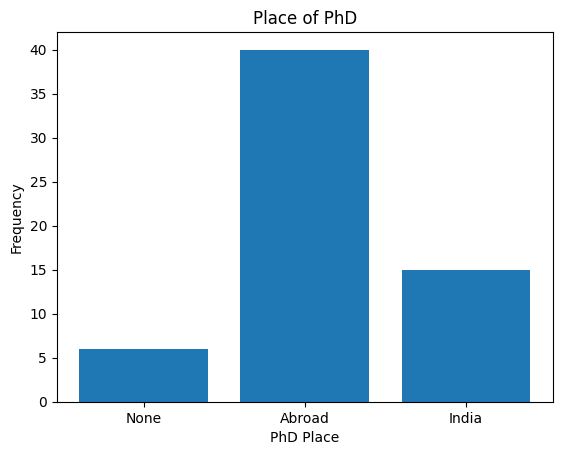

In [13]:
import matplotlib.pyplot as plt
from collections import Counter


# Count the occurrences of each year
year_counts = Counter(categories)

# Extract years and their corresponding counts
unique_years = list(year_counts.keys())
count_per_year = list(year_counts.values())

# Create a bar graph
plt.bar(unique_years, count_per_year)
plt.xlabel('PhD Place')
plt.ylabel('Frequency')
plt.title('Place of PhD')
plt.show()


In [14]:
# Regular expression pattern to match years (4 consecutive digits)
year_pattern = r'\b\d{4}\b'

# List to store Ph.D. years or None if no year is present
phd_years = []

# Extract years from the Ph.D. sentences using regular expressions
for sentence in phd_sentences:
    if sentence:
        year_matches = re.findall(year_pattern, sentence)
        # If years are found, append the first matched year; otherwise, append None
        phd_years.append(int(year_matches[0]) if year_matches else None)
    else:
        # If the sentence is None, append None to the list
        phd_years.append(None)




[2008, 2008, 2003, 2005, 2001, 2000, 2014, 2016, 2009, 2017, 2009, 2007, 2011, 1997, 1997, 2012, 2009, 1981, 2015, 2016, 2002, 2009, 2015, 2006, 2016, 2008, 1989, 2008, 2010, 2011, 2005, 2017, 1992, 2015, 1994, 2007, 2003, 2013, 2016, 1996, 2020, 2004, 2003, 2010, 2010, 2004, 2015, 1992, 1985, 2002, 2008]


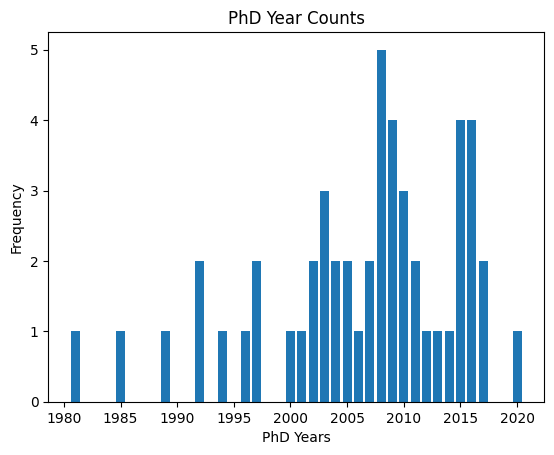

In [15]:
import matplotlib.pyplot as plt
from collections import Counter

phdyears = list(filter(None, phd_years))  #phd years list with None filtered out to plot graph
print(phdyears)

# Count the occurrences of each year
year_counts = Counter(phdyears)

# Extract years and their corresponding counts
unique_years = list(year_counts.keys())
count_per_year = list(year_counts.values())

# Create a bar graph
plt.bar(unique_years, count_per_year)
plt.xlabel('PhD Years')
plt.ylabel('Frequency')
plt.title('PhD Year Counts')
plt.show()


Extract the faculty position from SQL database & Plot graphs to find number of assistant professor, associate professor and professor.

In [16]:

conn = sqlite3.connect('faculty_engg_inf.db') 
cursor = conn.cursor()

# SQL query to extract a column from a table
sql_query = "SELECT position FROM faculty"
cursor.execute(sql_query)

position_list = [row[0] for row in cursor.fetchall()]

cursor.close()
conn.close()

print (position_list)



['Professor', 'Professor', 'Associate Professor', 'Associate Professor', 'Professor', 'Professor', 'Assistant Professor', 'Professor', 'Associate Professor', 'Assistant Professor', 'Associate Professor', 'Associate Professor', 'Assistant Professor', 'Professor', 'Associate Professor', 'Assistant Professor', 'Professor', 'Professor', 'Professor', 'Associate Professor', 'Associate Professor', 'Professor', 'Assistant Professor', 'Assistant Professor', 'Assistant Professor', 'Professor', 'Professor', 'Professor', 'Assistant Professor', 'Associate Professor', 'Associate Professor', 'Associate Professor', 'Assistant Professor', 'Associate Professor', 'Professor,(Ex.Director, IITDharwad)', 'Assistant Professor', 'Associate Professor', 'Associate Professor', 'Professor', 'Assistant Professor', 'Institute Chair Professor', 'Assistant Professor', 'Professor', 'Professor', 'Professor', 'Professor', 'Associate Professor', 'Associate Professor', 'Professor', '', 'Professor', 'Professor', 'Associate

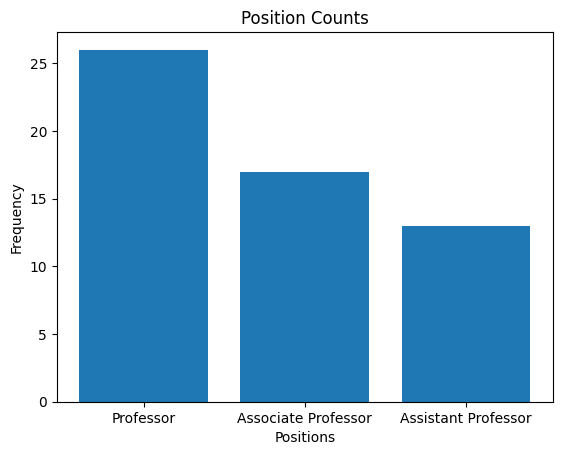

In [17]:
include = ['Associate Professor','Assistant Professor', 'Professor' ]  # to only include these in the pos_list
pos_list = [item for item in position_list if item in include]

# Count the occurrences of each year
year_counts = Counter(pos_list)

# Years and their corresponding frquency
_years = list(year_counts.keys())
count_year = list(year_counts.values())

# Bar graph
plt.bar(_years, count_year)
plt.xlabel('Positions')
plt.ylabel('Frequency')
plt.title('Position Counts')
plt.show()


Extract publication as list of lists and then count the number of publications of each faculty

In [18]:
import sqlite3


conn = sqlite3.connect('faculty_engg_inf.db') 
cursor = conn.cursor()

sql_query = "SELECT publications FROM faculty"
cursor.execute(sql_query)

rows = cursor.fetchall()
publication_list = [list(row) for row in rows]


cursor.close()
conn.close()

print (publication_list)


[['Ramalingam R., Atrey M.D.,Theoretical analysis and coating thickness determination of a dual layer metal coated FBG sensor for sensitivity enhancement at cryogenic temperatures,IOP Conference Series: Materials Science and Engineering,278,1,2017,12075.} Shukla A.K., Sridharan A., Atrey M.D.,Investigation of transient chill down phenomena in tubes using liquid nitrogen,IOP Conference Series: Materials Science and Engineering,278,1,2017,12035.} Bhojwani V., Inamdar A., Lele M., Tendolkar M., Atrey M., Bapat S., Narayankhedkar K.,Opposed piston linear compressor driven two-stage Stirling Cryocooler for cooling of IR sensors in space application,Cryogenics,83,,2017,71.} Patankar A.S., Atrey M.D.,Construction of Joule Thomson inversion curves for mixtures using equation of state,IOP Conference Series: Materials Science and Engineering,171,1,2017,12086.} Dev A.A., Atrey M.D., Vanapalli S.,Investigation of the effect of a bend in a transfer line that separates a pulse tube cold head and a p

In [19]:
for row_number, row_data in enumerate(publication_list, start=0):
    # Split each element in the inner list by '}' and count the parts
    pub_counts = [len(element.split('}')) for row_data in publication_list for element in row_data]
print(pub_counts)


[5, 5, 5, 1, 5, 5, 5, 5, 4, 1, 1, 2, 5, 5, 5, 5, 5, 4, 5, 5, 3, 5, 1, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 1, 5, 1, 5, 1, 5, 1, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5]


Correlation between the number of publication of the faculty member and their position

In [20]:
import pandas as pd
from scipy.stats import spearmanr


# Create a DataFrame
data = {'Position': position_list, 'Publications': pub_counts}
df = pd.DataFrame(data)


# Calculate Spearman's rank correlation
spearman_corr, _ = spearmanr(df['Position'], df['Publications'])

print(spearman_corr)





0.444848284289481


In [21]:
import sqlite3
#to get na,es as list

conn = sqlite3.connect('faculty_engg_inf.db')  
cursor = conn.cursor()
sql_query = "SELECT name FROM faculty"

cursor.execute(sql_query)

rows = cursor.fetchall()

name_list = [row[0] for row in rows]


cursor.close()
conn.close()
print (name_list)


['Prof. Milind Atrey', 'Prof. Krishna Jonnalagadda', 'Prof. Pradeep Dixit', 'Prof. Dnyanesh Pawaskar', 'Prof. Arunkumar Sridharan', 'Prof. P. S. Gandhi', 'Prof. Vivek Sangwan', 'Prof. Bhalchandra Puranik', 'Prof. Neeraj Kumbhakarna', 'Prof. Gurminder Singh', 'Prof. Shashikanth Suryanarayan', 'Prof. Shivasubramanian Gopalakrishnan', 'Prof. Darshan S. Shah', 'Prof. Rajneesh Bhardwaj', 'Prof. Abhilash J.Chandy', 'Prof. Ankit Jain', 'Prof. S. S. Joshi', 'Prof. S. V. Prabhu', 'Prof. Dhanesh N. Manik', 'Prof. Shyamprasad Karagadde', 'Prof. Parag U. Tandaiya', 'Prof. S. S. Pande', 'Prof. Amit Singh', 'Prof. Soham Mujumdar', 'Prof. Abhishek Gupta', 'Prof. Amit Agrawal', 'Prof. Sandip Kumar Saha', 'Prof. Asim Tewari', 'Prof. R. Ganesh', 'Prof. Dipanshu Bansal', 'Prof. V. Kartik', 'Prof. Shankar Krishnan', 'Prof. Nitesh P. Yelve', 'Prof. Sridhar Balasubramanian', 'Prof. P. Seshu', 'Prof. Shantanu Tripathi', 'Prof. Tanmay K. Bhandakkar', 'Prof. Rakesh G. Mote', 'Prof. Atul Srivastava', 'Prof. Jan

In [22]:
len(name_list)

61

Making data frame for some anlyses

In [23]:
df = pd.DataFrame({"Name": name_list, "Position": position_list, 'Year': phd_years, "Location": categories, "Number of publication": pub_counts})


In [24]:

# Define the titles you want to filter for
desired_titles = ['Professor', 'Assistant Professor', 'Associate Professor']

# Use conditional filtering to select rows with the desired titles
filtered_df = df[df['Position'].isin(desired_titles)]


In [25]:
filtered_df2 = filtered_df.dropna(subset=['Year'])
filtered_df2.reset_index(drop=True, inplace=True)
filtered_df2

,Name,Position,Year,Location,Number of publication
0,Prof. Krishna Jonnalagadda,Professor,2008.0,Abroad,5
1,Prof. Pradeep Dixit,Associate Professor,2008.0,Abroad,5
2,Prof. Dnyanesh Pawaskar,Associate Professor,2003.0,Abroad,1
3,Prof. Arunkumar Sridharan,Professor,2005.0,Abroad,5
4,Prof. P. S. Gandhi,Professor,2001.0,Abroad,5
5,Prof. Bhalchandra Puranik,Professor,2000.0,Abroad,5
6,Prof. Neeraj Kumbhakarna,Associate Professor,2014.0,Abroad,4
7,Prof. Gurminder Singh,Assistant Professor,2016.0,India,1
8,Prof. Shivasubramanian Gopalakrishnan,Associate Professor,2009.0,Abroad,2
9,Prof. Darshan S. Shah,Assistant Professor,2017.0,Abroad,5


Again plotting the graph of position vs frequency using data frame

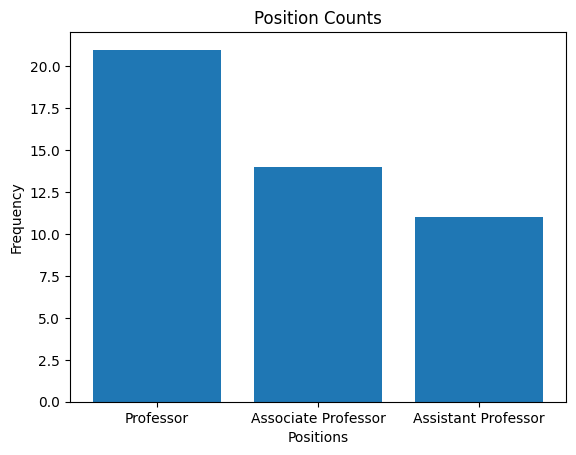

In [26]:
#include = ['Associate Professor','Assistant Professor', 'Professor' ]  # to only include these in the pos_list
pos_list = [item for item in filtered_df2['Position']]

# Count the occurrences of each year
year_counts = Counter(pos_list)

# Years and their corresponding frquency
_years = list(year_counts.keys())
count_year = list(year_counts.values())

# Bar graph
plt.bar(_years, count_year)
plt.xlabel('Positions')
plt.ylabel('Frequency')
plt.title('Position Counts')
plt.show()



Statitical analysis of year of PhD completion and number of publications

In [27]:
filtered_df2.loc[:, 'Year'] = pd.to_numeric(filtered_df2['Year'], errors='coerce')


In [28]:
# Calculate best-fit line (linear regression)
slope, intercept, r_value, p_value, std_err = linregress(filtered_df2['Year'], filtered_df2['Number of publication'])
line = slope * filtered_df2['Year'] + intercept

# Calculate predicted values
predicted_pub = slope * filtered_df2['Year'] + intercept

# Calculate mean squared error
mse = ((filtered_df2['Number of publication'] - predicted_pub) ** 2).mean()

# R-squared value, p-value, and mean squared error
print('r-squared:', r_value ** 2)
print('r-value:', r_value)
print('p-value:', p_value)
print('Mean Squared Error:', mse)

r-squared: 0.11031109547846915
r-value: -0.3321311419883254
p-value: 0.024129033935110115
Mean Squared Error: 2.126255571911807


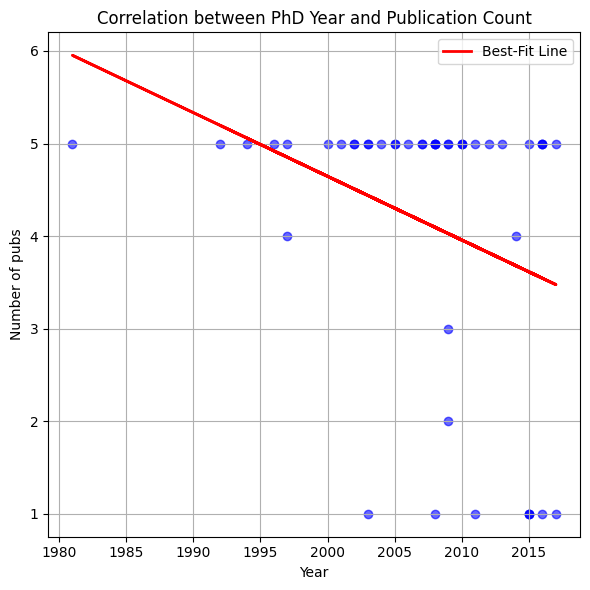

In [29]:

# Scatter plot 
plt.figure(figsize=(6, 6))
plt.scatter(filtered_df2['Year'], filtered_df2['Number of publication'], color='blue', alpha=0.6)
plt.title('Correlation between PhD Year and Publication Count')
plt.xlabel('Year')
plt.ylabel('Number of pubs')
plt.grid(True)

# Plot the best-fit line
plt.plot(filtered_df2['Year'], line, color='red', linewidth=2, label='Best-Fit Line')

plt.legend()
plt.tight_layout()
plt.show()

Statitical analysis for year and place of PhD 

In [30]:
# Separate the numerical variable 'years' based on the categories in 'location'
years_india = filtered_df2[filtered_df2['Location'] == 'India']['Year']
years_other = filtered_df2[filtered_df2['Location'] == 'Abroad']['Year']

# Perform independent two-sample t-test
t_stat, p_value = ttest_ind(years_india, years_other)

# Print the t-statistic and p-value
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -1.7813831081423457
P-value: 0.08175327656606488


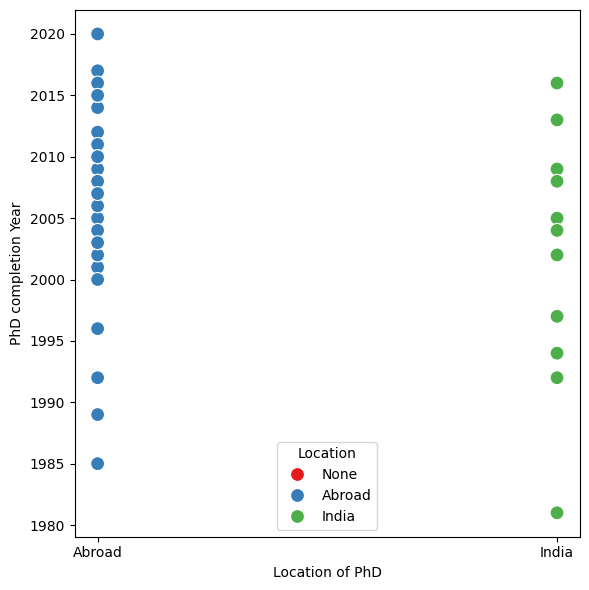

In [31]:
plt.figure(figsize=(6, 6))

sb.scatterplot(x='Location', y='Year', data=df, hue='Location', palette='Set1', s=100)
plt.xlabel('Location of PhD')
plt.ylabel('PhD completion Year')

plt.tight_layout()
plt.show()